# Projeto: Análise de Sentimentos em Discursos Políticos

<font color='gray'>Parte 1: Coleta de dados</font><br>
<font color='gray'>Parte 2: Limpeza de dados</font><br>
<font color='black'>**Parte 3: Modelagem e Análise de Sentimentos**</font>

![](./images/banner.svg)

Esta é a terceira e última parte deste projeto, no qual faremos alguma limpeza, se necessário, dos dados, a modelagem dos tópicos e a análise de sentimentos.

## Importando as bibliotecas

Iniciaremos importando as bibliotecas que serão utilizadas. As principais delas são:
* **SpaCy:** é uma biblioteca em Python para PLN em escala industrial, vamos utiliza-la para algumas transformações nos textos
* **scikit_learn:** para extrair informações dos textos
* **NMF:** para extração dos tópicos mais importantes
* **WordCloud:** para criação de núvem de palavras

In [1]:
# Manipulação de dados
import os
import re
import sys
import time
import string
import pickle
import requests
import datetime
import numpy as np
import pandas as pd

# Visualização de dados
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Processamento de Linguagem Natural
import spacy
from spacy.symbols import amod
from collections import Counter
from nltk.corpus import stopwords

# Topic Modeling
import sklearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

#importando as libraries necessárias para o wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

## Parte 3 - Topic Modeling

Modelagem de Tópicos é uma forma de mineração de texto, uma forma de identificar padrões. Construindo um corpus e executando uma ferramenta que gera grupos de palavras a respeito do corpus distribuídas em “tópicos”. 

Modelagem de tópicos é um método para achar e traçar clusters de palavras (chamado “tópicos” de forma abreviada) em grandes conjuntos de texto.

Aqui tem uma definição completa sobre o tema:

http://journalofdigitalhumanities.org/2-1/topic-modeling-a-basic-introduction-by-megan-r-brett/#topic-modeling-a-basic-introduction-by-megan-r-brett-n-1

Inicialmente carregamos o modelo pré-treinado em português do SpaCy. Esse modelo é de uso geral para prever entidades nomeadas, tags de classes gramaticais e dependências sintáticas e pode ser usado fora da caixa e ajustado em dados mais específicos.

In [2]:
# importando o modelo
import pt_core_news_sm

# instanciando o modelo pré-treinado
sp = pt_core_news_sm.load()

Carregando os discursos para comerçarmos a trabalhar e já vamos dar uma olhada nas primeiras linhas.

In [3]:
# carregando o banco de dados completo
with open('data/db_discurso_limpo.pickle', 'rb') as read_file:
    db_final = pickle.load(read_file)
    
# visualizando
db_final.head()

,data,hora,link,text,monologue
0,2020-11-22,11:16:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Primeiramente parabenizo ...,senhoras e senhores primeiramente parabenizo a...
1,2020-11-21,11:20:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Antes de adentrarmos o te...,senhoras e senhores antes de adentrarmos o tem...
2,2020-11-18,14:52:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Mais que emocionado eu estou muito feliz em p...,mais que emocionado eu estou muito feliz em po...
3,2020-11-17,18:12:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Brasília/DF 17 de novembro de 2020 Sua Excelê...,brasília/df 17 de novembro de 2020 sua excelên...
4,2020-10-11,20:49:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[ Boa tarde. Senhores e senhoras se me permite...,boa tarde. senhores e senhoras se me permitem ...


Faremos algumas funções anônimas que extraem alguns padrões como caracteres alphanuméricos, pontuações e espaços a mais, isso tudo com o uso de *regex*.

In [4]:
# remover caracteres alphanuméricos
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)

# remover pontuações
punc = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x)

# remover espaços duplos
remove_space = lambda x: x.replace('  ', ' ')

# aplicando as funções
db_final['for_spacy'] = (db_final['monologue'].map(alphanumeric).map(punc).map(remove_space))

Vamos dar uma olhada em como ficou.

In [5]:
# visualizando
db_final.head(2)

,data,hora,link,text,monologue,for_spacy
0,2020-11-22,11:16:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Primeiramente parabenizo ...,senhoras e senhores primeiramente parabenizo a...,senhoras e senhores primeiramente parabenizo a...
1,2020-11-21,11:20:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Antes de adentrarmos o te...,senhoras e senhores antes de adentrarmos o tem...,senhoras e senhores antes de adentrarmos o tem...


Passamos o modelo pré-treinado em cada discurso e agora com o modelo aprendido, podemos usufruir dos métodos do SpaCy.

In [6]:
# aplicando o modelo de linguagem (sp) do SpaCy
db_final['spacy_monologue'] = db_final['for_spacy'].map(lambda x: sp(x))

# visualizando
db_final.head(2)

,data,hora,link,text,monologue,for_spacy,spacy_monologue
0,2020-11-22,11:16:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Primeiramente parabenizo ...,senhoras e senhores primeiramente parabenizo a...,senhoras e senhores primeiramente parabenizo a...,"(senhoras, e, senhores, primeiramente, paraben..."
1,2020-11-21,11:20:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Antes de adentrarmos o te...,senhoras e senhores antes de adentrarmos o tem...,senhoras e senhores antes de adentrarmos o tem...,"(senhoras, e, senhores, antes, de, adentrarmos..."


Lematização é o processo de extrair o lema de cada palavra, tarefa fundamental em PLN. Não precisamos da palavra inteira, somente do seu lema.

Vamos utilizar o método do *SpaCy* e vamos informar para utilizar em palavras diferentes de pronomes.

In [7]:
# aplicando lematização
db_final['lemmatized'] = (db_final['spacy_monologue']
                          .map(lambda x: [' '.join(word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in x)][0]))

# visualizando
db_final.head()

,data,hora,link,text,monologue,for_spacy,spacy_monologue,lemmatized
0,2020-11-22,11:16:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Primeiramente parabenizo ...,senhoras e senhores primeiramente parabenizo a...,senhoras e senhores primeiramente parabenizo a...,"(senhoras, e, senhores, primeiramente, paraben...",senhor e senhor primeiramente parabenizar o ar...
1,2020-11-21,11:20:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Antes de adentrarmos o te...,senhoras e senhores antes de adentrarmos o tem...,senhoras e senhores antes de adentrarmos o tem...,"(senhoras, e, senhores, antes, de, adentrarmos...",senhor e senhor antar de adentrar o temer prin...
2,2020-11-18,14:52:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Mais que emocionado eu estou muito feliz em p...,mais que emocionado eu estou muito feliz em po...,mais que emocionado eu estou muito feliz em po...,"(mais, que, emocionado, eu, estou, muito, feli...",mais que emocionar eu estar muito feliz em pod...
3,2020-11-17,18:12:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Brasília/DF 17 de novembro de 2020 Sua Excelê...,brasília/df 17 de novembro de 2020 sua excelên...,brasília df de novembro de sua excelência vlad...,"(brasília, df, de, novembro, de, sua, excelênc...",brasília df de novembro de suar excelência vla...
4,2020-10-11,20:49:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[ Boa tarde. Senhores e senhoras se me permite...,boa tarde. senhores e senhoras se me permitem ...,boa tarde senhores e senhoras se me permitem e...,"(boa, tarde, senhores, e, senhoras, se, me, pe...",bom tardar senhor e senhor se me permitir eu q...


Aqui nós criamos uma lista de stop words palavras que não são relevantes para esta análise e também vamos utilizar a função `CountVectorizer`, no qual nos apresenta as palavras e as suas respectivas frequencias nos textos.

Podemos passar alguns parâmetros para ajudar com as análises das palavras certas:
* **max_df:** ignora palavras que são comuns entre os documentos e acabam se tornando stopwords, podemos passar em números absolutos ou proporção dos documentos, neste caso passaremos **0.95**, ou seja, as palavras que aparecem em mais de 95% dos documentos.
* **min_df:** ignora os documentos que aparecem menos que o hiperparâmetro passado, neste caso vamos passar o número **2** e isso significa que serão ignoradas as palavras que aparecem em menos de 2 documentos.
* **ngram_range:** é o limite inferior e superior de palavras a serem extraidas, no nosso caso utilizaremos somente *bigrams*, ou seja, **(2,2)**.
* **max_features:** Com esse parâmetro podemos limitar a quantidade de palavras extraidas, isso ajuda porque dependendo do tamanho do texto, podemos ter muitas palavras e como nós já teremos uma matriz esparsa, essa quantidade de *zeros* pode ser muito maior e isso pode ser ruim para o nosso modelo, depende do seu objetivo e qual fica melhor, no nosso caso utilizarei como **5000**.

In [8]:
# instanciando a lista de stopwords
stopwords = set(stopwords.words('portuguese'))

# Configurando max_df para 0,5 e min_df = 2, porque estes forneceram os melhores tópicos
cv = CountVectorizer(stop_words=stopwords, max_df=0.95, min_df=2, ngram_range=(2,2), max_features=5000)

# Cria a matriz de documentos, que basicamente contém palavras em representações numéricas
docterm_matrix = cv.fit_transform(db_final.loc[:, 'lemmatized'])

Se desejarmos podemos ver as palavras ignoradas internamente com os parâmetros informados, podemos utilizar o método `stop_words_`.

Assim como também podemos checar o vocabulário que restou com suas respectivas frequencias com o método `vocabulary_`.

In [9]:
## palavras removidas
# cv.stop_words_

# vocabulario com as respectivas frequencias
cv.vocabulary_

{'senhor senhor': 3613,
 'arábio saúde': 274,
 'ter escolher': 4304,
 'parir todo': 2636,
 'longo ano': 1941,
 'melhorar prático': 2046,
 'bem comer': 331,
 'senhor brasil': 3583,
 'brasil ser': 458,
 'ser país': 3836,
 'desenvolvimento sustentável': 960,
 'oportunidade parir': 2422,
 'parir população': 2599,
 'governar ter': 1669,
 'umar maior': 4613,
 'comércio investimento': 745,
 'mundial ser': 2193,
 'acordo comerciar': 35,
 'mercosul união': 2053,
 'união europeu': 4673,
 'europeu associação': 1397,
 'associação europeu': 284,
 'europeu livrar': 1398,
 'livrar comércio': 1935,
 'coreia sul': 831,
 'entrar brasil': 1197,
 'brasil eua': 418,
 'facilitação comércio': 1433,
 'combater corrupção': 666,
 'corrupção estar': 834,
 'estar construir': 1304,
 'aberto parir': 2,
 'parir mundo': 2576,
 'cada vez': 520,
 'último ano': 4985,
 'ano brasil': 154,
 'brasil passar': 443,
 'quase bilião': 3327,
 'bilião mear': 366,
 'garantir segurança': 1613,
 'segurança alimentar': 3557,
 'ser rea

*Bigrams* mostram duas palavras que aparecem na sequencia, no nosso caso foi "senhor senhor", analizando os discursos podemos perceber que praticamentes todos começam com "senhoras e senhores", no resultado apareceu assim em função do *lemma* que extraimos anteriormente.

Se o "senhor senhor" ou outras palavras não agregarem valor para o que nós precisamos podemos ignora-las customizando a lista de *stopwords*.

Vamos dar uma olhada na resultante da nossa matriz esparsa, a quantidade de colunas foi deve ser 5000, que foi o limite que especificamos ao instanciar o *CountVectorizer*, enquanto a quantidade de linhas, no nosso caso, é a quantidade de discursos.

In [10]:
# dimensão da matriz formada
docterm_matrix.shape

(150, 5000)

Em seguida, classificamos as palavras no vetor em ordem decrescente dos valores obtidos pelo *CountVectorizer* e, em seguida, iteramos para extrair as n palavras-chave principais.

Criaremos uma função com o método `sort_coo` que, essencialmente classifica os valores no vetor enquanto preserva o índice da coluna. Depois de ter o índice da coluna, é realmente fácil procurar o valor da palavra correspondente.

In [11]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """return n-gram counts in descending order of counts"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    results=[]
    
    # word index, count i
    for idx, count in sorted_items:
        
        # get the ngram name
        n_gram=feature_names[idx]
        
        # collect as a list of tuples
        results.append((n_gram,count))

    return results

Executamos as funções para obter os top 10 *n_grams* de acordo com os hiperparâmetros inseridos no *CountVectorizer*.

In [12]:
# classificando a contagem
sorted_items=sort_coo(docterm_matrix[0].tocoo())

# relacionando as palavras, classificado pela posição na matriz
feature_names=cv.get_feature_names()
n_grams=extract_topn_from_vector(feature_names,sorted_items,10)

# visualizando o resultado
n_grams

[('emissão carbono', 3),
 ('desenvolvimento sustentável', 3),
 ('brasil ser', 3),
 ('acordo comerciar', 3),
 ('umar maior', 2),
 ('ter orgulhar', 2),
 ('senhor senhor', 2),
 ('mundial ser', 2),
 ('dizer brasil', 2),
 ('bem comer', 2)]

Agora faremos a mesma coisa, porém ao invés de termos a quantidade, teremos a pontuação de cada palavra que aparecem nos textos, essa pontuação é definida pelo `tf-idf`, termo em inglês que siginifica *term frequency–inverse document frequency*, ou em português *frequência do termo–inverso da frequência nos documentos*.

O valor *tf–idf* é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Ela é frequentemente utilizada como fator de ponderação na recuperação de informações e na mineração de dados.

O valor de uma palavra aumenta proporcionalmente à medida que aumenta o número de ocorrências dela em um documento, no entanto, esse valor é equilibrado pela frequência da palavra no corpus. Isso auxilia a distinguir o fato da ocorrência de algumas palavras serem geralmente mais comuns que outras.

Passaremos os mesmos argumentos que passamos com o *CountVectorizer*.

In [13]:
# instanciando o tf-idf
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, max_df=0.95, min_df=2, ngram_range=(2,2), max_features=5000)

# executando o tf-idf
tfidf = tfidf_vectorizer.fit_transform(db_final.loc[:, 'lemmatized'])

In [14]:
# classicando a pontuação
sorted_items=sort_coo(tfidf[0].tocoo())

# relacionando as palavras, classificado pela posição na matriz
feature_names_tfidf=tfidf_vectorizer.get_feature_names()
n_grams_tfidf=extract_topn_from_vector(feature_names,sorted_items,10)

# visualizando o resultado
n_grams_tfidf

[('acordo comerciar', 0.32280380352377624),
 ('emissão carbono', 0.3039237173451473),
 ('desenvolvimento sustentável', 0.2892791847779546),
 ('mundial ser', 0.21520253568251752),
 ('umar maior', 0.1848758202870261),
 ('ter orgulhar', 0.1848758202870261),
 ('dizer brasil', 0.1848758202870261),
 ('brasil ser', 0.12730200123472807),
 ('sempre parir', 0.10760126784125876),
 ('preservar vegetação', 0.10760126784125876)]

Agora vamos definir os tópicos e as 10 palavras mais importantes por tópico.

In [15]:
# definindo a função para extrair os tópicos
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

Vamos utilizar o framework NMF do *scikit-learn*, Fatoração de Matriz Não Negativa e Alocação de Dirichlet Latente (tradução em português) em um corpus de documentos para extrair modelos aditivos da estrutura de tópicos do corpus. A saída é uma **lista de tópicos**, cada um representado como uma lista de termos (pesos não são mostrados).

Vamos utilizar o modelo para extrair os tópicos

In [16]:
# instanciando o NMF
nmf_tf = NMF(10)

# treinando o tfidf para NMF
nmf_topics1 = nmf_tf.fit_transform(tfidf)

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [17]:
# Função para encontrar as palavras mais importantes por tópico
def top_words_per_topic(model, terms, topic_names = None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTópico ", ix)
        else:
            print("\nTópico '",topic_names[ix],"'")
        print(", ".join([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[:-10 - 1:-1]]))

In [18]:
top_words_per_topic(nmf_tf, tfidf)


Tópico  0
nó ter, ser umar, ter umar, haver pouco, estar aqui, comer ser, dar certar, cada vez, brasil ter, ser ser

Tópico  1
desenvolvimento sustentável, senhor senhor, entrar brasil, arábio saúde, mario abdo, senhor presidente, cada vez, estar unir, união europeu, brasil ser

Tópico  2
acima tudo, brasil acima, deus acima, estar mudar, mudar destinar, tudo deus, acima todo, destinar brasil, estar aqui, dever lealdade

Tópico  3
oferecer parir, narendra modi, ter oferecer, brasil índio, véspera dessar, potencial nação, potencializar fazer, povo assinar, ver horar, índio estar

Tópico  4
aéreo brasileiro, forçar aéreo, forçar armar, todo nó, exército brasileiro, prezar general, evento comer, fernando azevedo, militar agulhar, academiar militar

Tópico  5
ser médico, comprovação científico, naquele momento, umar decisão, ter ser, ser parir, ministrar saudar, salvar vidar, ser umar, ser ser

Tópico  6
paulo guedes, todo nó, câmara senado, auxílio emergencial, senhor governador, deus qu

## Parte 4 - Análise de Sentimentos

Esta é a última parte do trabalho.

Pesquisei alguns frameworks e tive dificuldades de encontrar bibliotecas mais robustas no idioma em português, entenda como um MVP este trabalho e que podemos melhorar mais a frente.

Utilizarei um dicionário de sentimentos, o `Sentilex-PT02` que é um léxico de sentimentos para o idioma em português. Ele é útil especialmente para aplicações de mineração de opinião, em particular para detectar sentimentos e classificá-los.

Primeiro vamos carregar o arquivo que contém as palavras e suas polaridades:
* +1 sentimento positivo
* 0 neutro
* -1 sentimento negativo

In [19]:
sentilexpt = open('SentiLex/SentiLex-lem-PT01.txt','r')

Depois de colocar em um objeto, vamos criar o dicionário, porque contém outras informações no arquivo.

In [20]:
#Criando um dicionário de palavras com a respectiva polaridade.
dic_palavra_polaridade = {}
for i in sentilexpt.readlines():
    pos_ponto = i.find('.')
    palavra = (i[:pos_ponto])
    pol_pos = i.find('POL')
    polaridade = (i[pol_pos+4:pol_pos+6]).replace(';','')
    dic_palavra_polaridade[palavra] = polaridade


#Verificando o dicionário
dic_palavra_polaridade

{'ï»¿abafado': '-1',
 'abafante': '-1',
 'abaixado': '-1',
 'abalado': '-1',
 'abalizado': '1',
 'abandalhado': '-1',
 'abandonado': '-1',
 'abarcante': '-1',
 'abarrotado': '-1',
 'abastado': '1',
 'abastecido': '0',
 'abatido': '-1',
 'abelhudo': '-1',
 'abenÃ§oado': '1',
 'aberrante': '-1',
 'aberrativo': '-1',
 'aberto': '1',
 'abespinhado': '-1',
 'abestalhado': '-1',
 'abilolado': '-1',
 'abismado': '-1',
 'abismal': '-1',
 'abjecto': '-1',
 'abjeto': '-1',
 'abnegado': '1',
 'abobado': '-1',
 'abobalhado': '-1',
 'abolicionista': '0',
 'abolido': '-1',
 'abominador': '-1',
 'abominando': '-1',
 'abominÃ¡vel': '-1',
 'abonado': '1',
 'abonatÃ³rio': '1',
 'abonecado': '0',
 'aborÃ\xadgene': '-1',
 'aborrecido': '-1',
 'abortado': '-1',
 'abraÃ§ado': '1',
 'abrangente': '-1',
 'abrangido': '-1',
 'abrasileirado': '0',
 'abrigado': '0',
 'abrilhantado': '1',
 'abrupto': '-1',
 'abrutalhado': '-1',
 'absentista': '-1',
 'absolutista': '0',
 'absoluto': '0',
 'absolvido': '0',
 'absor

Podemos observar como ficou o dicionário, somente com as polaridades que indicam os sentimentos.

Vamos criar um função que retorna a polaridade, *positivo, neutro ou negativo*.

In [21]:
#Criando uma função chamada "Score de Sentimento" para determinar os #sentimentos associados
def Score_sentimento(frase):
    frase = frase.lower()
    l_sentimento = []
    for p in frase.split():
        l_sentimento.append(float(dic_palavra_polaridade.get(p, 0)))
    score = sum(l_sentimento)
    if score > 0:
        return 'Positivo: {} '.format(score)
#         return '{}'.format(score)
    elif score == 0:
        return 'Neutro: {} '.format(score)
#         return '{}'.format(score)
    else:
#         return '{}'.format(score)
        return 'Negativo: {}'.format(score)

A função acima retornará nesse formato, por exemplo, "Positivo: 2.0", então na sequencia eu vou separar mantendo a polaridade em uma coluna e o score em outra.

In [22]:
# aplicando a função para entender os sentimentos de cada discurso
db_final['sentimento'] = db_final.apply(lambda row: Score_sentimento(row['lemmatized']), axis=1)

# separando a polaridade do score
db_final[['polaridade', 'score']] = db_final['sentimento'].str.split(':', expand=True)

# removendo a coluna original
db_final = db_final.drop(['sentimento'], axis=1)

# visualizando o resultado
db_final.head()

,data,hora,link,text,monologue,for_spacy,spacy_monologue,lemmatized,polaridade,score
0,2020-11-22,11:16:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Primeiramente parabenizo ...,senhoras e senhores primeiramente parabenizo a...,senhoras e senhores primeiramente parabenizo a...,"(senhoras, e, senhores, primeiramente, paraben...",senhor e senhor primeiramente parabenizar o ar...,Positivo,8.0
1,2020-11-21,11:20:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Senhoras e Senhores Antes de adentrarmos o te...,senhoras e senhores antes de adentrarmos o tem...,senhoras e senhores antes de adentrarmos o tem...,"(senhoras, e, senhores, antes, de, adentrarmos...",senhor e senhor antar de adentrar o temer prin...,Positivo,9.0
2,2020-11-18,14:52:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Mais que emocionado eu estou muito feliz em p...,mais que emocionado eu estou muito feliz em po...,mais que emocionado eu estou muito feliz em po...,"(mais, que, emocionado, eu, estou, muito, feli...",mais que emocionar eu estar muito feliz em pod...,Positivo,3.0
3,2020-11-17,18:12:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[Brasília/DF 17 de novembro de 2020 Sua Excelê...,brasília/df 17 de novembro de 2020 sua excelên...,brasília df de novembro de sua excelência vlad...,"(brasília, df, de, novembro, de, sua, excelênc...",brasília df de novembro de suar excelência vla...,Positivo,14.0
4,2020-10-11,20:49:00,https://www.gov.br/planalto/pt-br/acompanhe-o-...,[ Boa tarde. Senhores e senhoras se me permite...,boa tarde. senhores e senhoras se me permitem ...,boa tarde senhores e senhoras se me permitem e...,"(boa, tarde, senhores, e, senhoras, se, me, pe...",bom tardar senhor e senhor se me permitir eu q...,Positivo,14.0


Depois dos sentimentos já encontrados em cada discurso, vamos fazer algumas análises.

Primeiramente, vou medir os discursos e colocar em uma coluna a quantidade de palavras.

In [23]:
# medindo os textos
db_final['lenght'] = db_final['lemmatized'].apply(lambda x: len(x))

A seguir vou fazer 3 histogramas e analisar a distribuição do tamanho dos textos por polaridade, será que tem alguma relação?

Média de palavras nos discursos Positivo: 5114.86 e desvio padrão: 3857.22
Média de palavras nos discursos Neutro: 1968.00 e desvio padrão: 1670.96
Média de palavras nos discursos Negativo: 2777.27 e desvio padrão: 1789.53


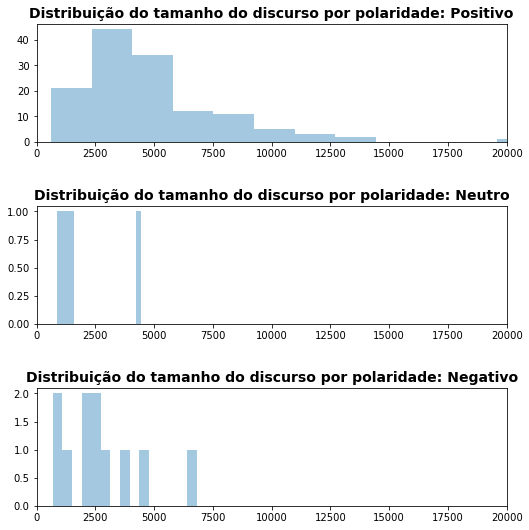

In [24]:
# colocando a polaridade em uma lista dos unicos existentes
polarity = db_final.polaridade.unique().tolist()

# definindo a área de plotagem
fig, ax = plt.subplots(nrows=len(polarity), figsize=(8,8))

# loop para criar os histogramas com seus respectivos parâmetros
for i in range(len(polarity)):
    sns.distplot(db_final[db_final.polaridade == polarity[i]]['lenght'], ax=ax[i], kde=False, bins=15)
    ax[i].set_xlim(0, 20000)
    ax[i].set_title(f'Distribuição do tamanho do discurso por polaridade: {polarity[i]}', fontsize=14, fontweight='bold')
    ax[i].set_xlabel(None)
    print(f"Média de palavras nos discursos {polarity[i]}: {db_final[db_final.polaridade == polarity[i]]['lenght'].mean():.2f} e desvio padrão: {db_final[db_final.polaridade == polarity[i]]['lenght'].std():.2f}")

# ajusta o espaçamento entre os plots
plt.tight_layout(pad=3)

Podemos observar que os discursos classificados como positivos tem uma variação maior que os outros dois sentimentos, tendo praticamente o dobro de desvio-padrão e uma distribuição bem diferente entre eles.

Podemos contruir uma `wordcloud`, ou seja, uma núvem de palavras, assim conseguimos ver visualmente, com base no tamanho das palavras, que quanto maior, mais ela é frequente nos discursos.

Temos que juntar todas as palavras como se fosse um só texto.

In [25]:
# juntando todos eles para construir a wordcloud - ela tem que estar todo contido numa string
all_content = "".join(c for c in db_final['lemmatized'])

Se quiser podemos customizar uma lista de *stopwords* e ir ajustando a nuvem de palavras.

In [26]:
# customizando stopwords
stopwords.update(['ser', 'não', 'ter', 'parir', 'um', 'aí', 'ma', 'pelar', 'então'])

Uma outra coisa que vamos fazer é colocar a núvem de palavras em um formato que também represente, ou próximo disso, do que se trata o projeto. Como estamos falando de sentimentos em discursos políticos, vamos colcar a *wordcloud* em formato da bandeira do brasil.

In [27]:
# definindo uma imagem como máscara
mask = np.array(Image.open("images/brasil.jpg"))

A imagem como máscara deve ser criada em branco e preto, fiz em power-point mesmo, a parte que não terá palavras deve ser branco e o restante preto, então exportamos a imagem com o método `Image.open` da biblioteca `PIL` e convertemos os pixels em *array numpy* como a função `np.array`, armazenando em um objeto *mask*.

Esse objeto servirá como argumento do parâmetro *mask* da função `WordCloud`, além de ajustar também outros parâmetros.

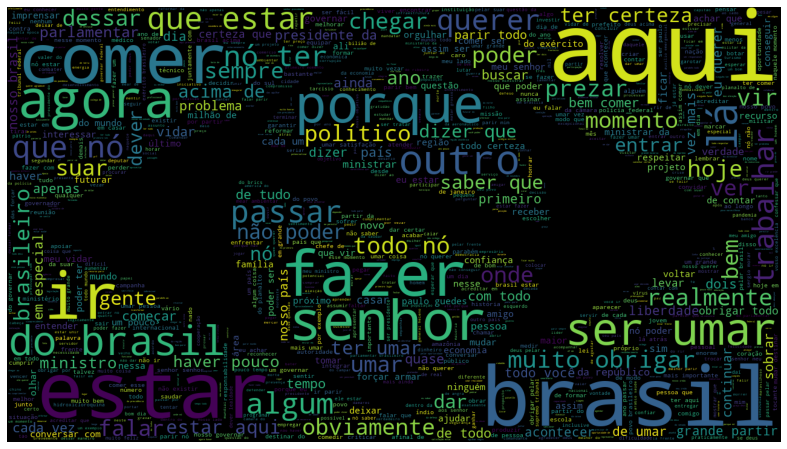

In [28]:
# Criando o objeto wordcloud com as configs necessárias
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black', width=1600,
                      height=800, max_words=1000, mask=mask, max_font_size=500,
                      min_font_size=1).generate(all_content)


#configurando forma de apresentação do gráfico e apresentando no notebook.
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

Vamos criar um `countplot` para ver a quantidade por cada tipo de polaridade.

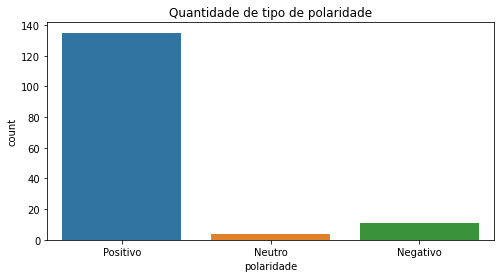

In [29]:
# definindo a área de plotagem
plt.figure(figsize=(8,4))

# criando o plot
sns.countplot(db_final['polaridade'])

# definindo o título
plt.title('Quantidade de tipo de polaridade');

Vemos que discursos com sentimentos positivos prevalecem entre todos os discursos realizados.

Iremos fazer uma análise da dimensão temporal pra ver o quanto oscila os sentimentos entre os discursos, utilizaremos um agrupamento por data, com as médias do score. Vamos utilizar a média porque constatamos que há dias que tiveram mais de um discurso.

Vamos criar um dataframe somente para a dimensão temporal, uma coluna para os *scores* e uma com uma média móvel de 7 dias, ou seja, a granularidade será semanal para visualizarmos.

In [30]:
# convertendo a coluna score em float
db_final['score'] = db_final['score'].astype(float)

# criando o dataframe
db_final_temporal = pd.DataFrame(db_final.groupby(['data'])['score'].mean())

# criando a janela temporal com a média
db_final_temporal['score_roll_avg'] = db_final_temporal.rolling(window=7).mean()

# visualizando o resultado
db_final_temporal.head(10)

,score,score_roll_avg
data,,
2019-02-12,9.5,NaN
2019-03-12,5.0,NaN
2019-04-11,-1.0,NaN
2019-05-11,19.0,NaN
2019-05-12,4.0,NaN
2019-06-12,12.0,NaN
2019-07-12,7.0,7.928571
2019-08-11,12.0,8.285714
2019-09-12,2.5,7.928571


Plotaremos dois tipos de gráficos:
1. Primeiro será somente com os scores sem nenhum tipo de transformação, para analisar o comportamento ao longo do tempo.
2. Segundo será o plot com a média móvel.

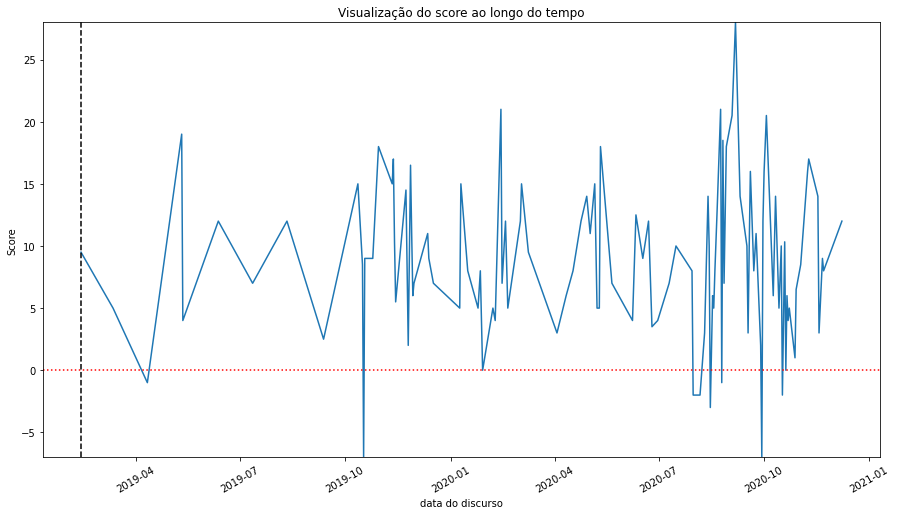

In [31]:
# definindo a área de plotagem
fig = plt.figure(figsize=(15,8))
ax = plt.axes()

# criando o plot
sns.lineplot(x = db_final_temporal.index, y = db_final_temporal.score)

# definindo o título
plt.title('Visualização do score ao longo do tempo')

# configurando eixos
plt.xlabel('data do discurso')
plt.ylabel('Score')
plt.ylim(db_final_temporal.score.min(), db_final_temporal.score.max())
plt.axhline(y = 0, color = 'red', linestyle = ':')
plt.axvline(x = db_final_temporal.index.min(), color = 'black', linestyle = 'dashed')
plt.xticks(rotation = 30);

A linha vermelha corresponde o **neutro**, podemos obervar que em outubro de 2019 houve um discurso com sentido bem negativo, embora os discursos nessa amostragem seja, em sua grande maioria **positivo**. Vemos que a partir de agosto de 2020 os discursos começaram oscilar mais, sendo realizados mais discursos em tons **negativos**. Poderíamos averiguar o que aconteceu a partir desta data que alterou esse comportamento.

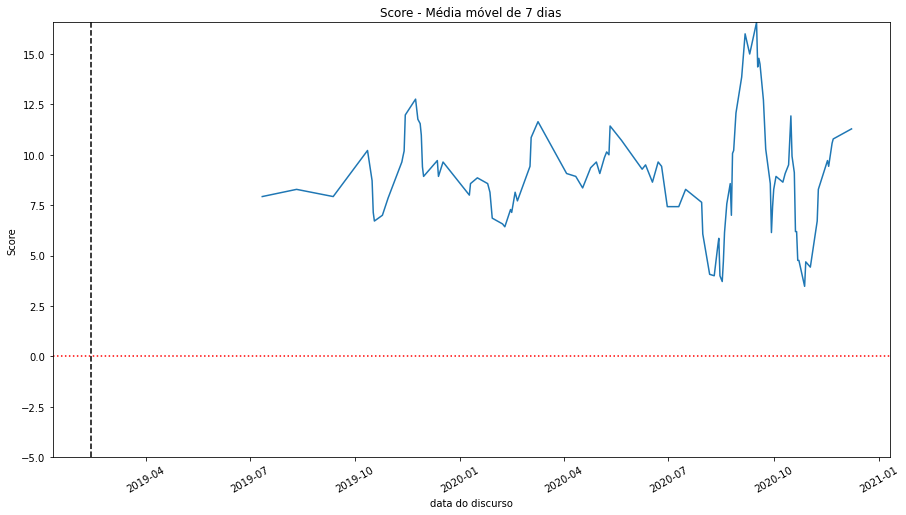

In [32]:
# definindo a área de plotagem
fig = plt.figure(figsize=(15,8))
ax = plt.axes()

# criando o plot
sns.lineplot(x = db_final_temporal.index, y = db_final_temporal.score_roll_avg)

# definindo o título
plt.title('Score - Média móvel de 7 dias')

# configurando eixos
plt.xlabel('data do discurso')
plt.ylabel('Score')
plt.ylim(-5, db_final_temporal.score_roll_avg.max())
plt.axhline(y = 0, color = 'red', linestyle = ':')
plt.axvline(x = db_final_temporal.index.min(), color = 'black', linestyle = 'dashed')
plt.xticks(rotation = 30);

Podemos observar no gráfico que de julho/2020 à agosto/2020, a pontuação começou a decrescer muito, mesmo que na média desse período tenha ficado **positivo**, dá pra constatar que o tom dos discursos foram mais negativos e a partir daí os discursos deram um pico de positividade, mas começaram a oscilar mais que anterior à esta data.

## Conclusão

Nosso trabalho termina aqui por enquanto, fomos desde a definição do problema até a análise dos sentimentos passando pelos seguintes passos: **Coleta de dados**, fizemos web scraping para obtenção dos dados, **limpeza dos dados**, no qual extraimos todos os textos do código fonte da página html, **modelagem dos tópicos** no qual definimos os tópicos mais relevantes com as 10 palavras mais importantes e **análise de sentimentos** feito com um léxico de sentimentos, por fim, para fecharmos as análises vimos como são os discursos ao longo do tempo.

## Referências

Data Science Academy<br>
https://www.datascienceacademy.com.br/

spaCy em Português (Aula)<br>
https://www.youtube.com/watch?v=1pGe5OSbbDg&list=PL4OAe-tL47saZwtt9fLHmT5cas57rjCCW

analise-de-sentimentos-de-uma-forma-diferente<br>
https://minerandodados.com.br/analise-de-sentimentos-de-uma-forma-diferente/

Analisando Sentimento em notas de app (Python) – Parte 1 <br>
https://escoladeia.com.br/analisando-sentimento-em-notas-de-app-python-parte-1/

Brincando de Processamento Natural de Linguagem com spaCy<br>
https://leportella.com/pt-br/npl-com-spacy/